In [22]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# file_path = '/content/drive/My Drive/path/to/your/file.txt'
# with open(file_path, 'r') as file:
#     content = file.read()
#     print(content)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)


train_ds = image_dataset_from_directory(
    '/content/drive/My Drive/hotdog-nothotdog/hotdog-nothotdog/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
valid_ds = image_dataset_from_directory(
    '/content/drive/My Drive/hotdog-nothotdog/hotdog-nothotdog/test',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

Found 4242 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [19]:
# Converting data to float
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
valid_ds = (
    valid_ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [20]:
# Load pretrained model Xception
pretrained_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=[128,128,3],
)
pretrained_model.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


In [23]:
model = keras.Sequential([
    # Preprocessing images
    pretrained_model,

    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 64)                131136    
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [24]:
model.compile(optimizer = 'adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [25]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=4,
    shuffle=True,
)

Epoch 1/4
67/67 [==============================] - 383s 5s/step - loss: 0.3493 - accuracy: 0.8484 - val_loss: 0.3724 - val_accuracy: 0.8600
Epoch 2/4
67/67 [==============================] - 6s 88ms/step - loss: 0.2469 - accuracy: 0.8965 - val_loss: 0.3257 - val_accuracy: 0.8725
Epoch 3/4
67/67 [==============================] - 6s 91ms/step - loss: 0.2121 - accuracy: 0.9123 - val_loss: 0.3298 - val_accuracy: 0.8725
Epoch 4/4
67/67 [==============================] - 6s 88ms/step - loss: 0.1795 - accuracy: 0.9269 - val_loss: 0.3352 - val_accuracy: 0.8575


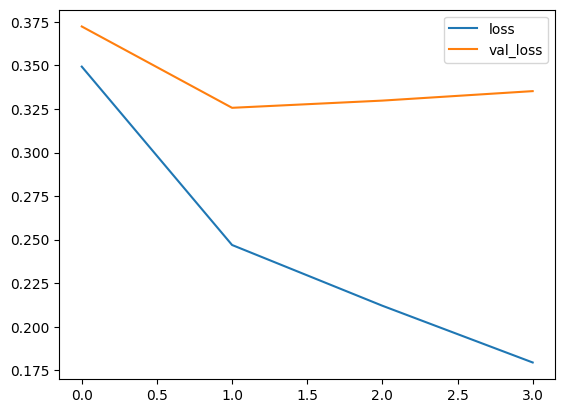

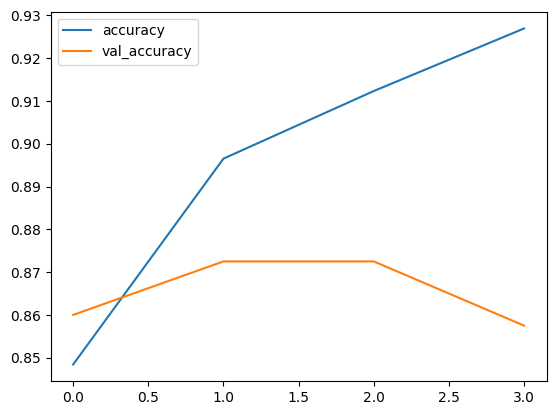

In [26]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [30]:
model.save('/content/model_autotune.h5')